In [2]:
# !pip install tensorflow==2.8.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib
import cv2 as cv
import tensorflow as tf
from tensorflow import keras, cast
from keras.layers import InputLayer, Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomZoom, RandomTranslation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

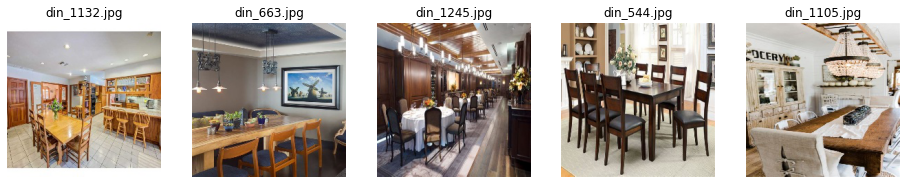

In [ ]:
img_folder = '/content/drive/MyDrive/Megaproyecto/House_Room_Dataset/Dinning'
# img_folder = './House_Room_Dataset/Dinning'
plt.figure(figsize=(16, 8))
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    ax.axis('off')
    plt.imshow(img)

In [ ]:
IMG_WIDTH=224
IMG_HEIGHT=224

def createDS(image_folder):
    batch_size = 32
    DEFAULT_SEED = 1234
    train_ds = keras.utils.image_dataset_from_directory(
        image_folder,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        shuffle=True,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        color_mode='grayscale',
        validation_split=0.2,
        seed=DEFAULT_SEED,
        interpolation='gaussian',
        subset="training",
    )
    
    val_ds = keras.utils.image_dataset_from_directory(
        image_folder,
        labels='inferred',
        batch_size=batch_size,
        label_mode='int',
        color_mode='grayscale',
        validation_split=0.2,
        seed=DEFAULT_SEED,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        subset="validation",
    )

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = createDS('/content/drive/MyDrive/Megaproyecto/House_Room_Dataset')

Found 5250 files belonging to 5 classes.
Using 4200 files for training.
Found 5250 files belonging to 5 classes.
Using 1050 files for validation.


In [ ]:
train_ds.class_names

['Bathroom', 'Bedroom', 'Dinning', 'Kitchen', 'Livingroom']

In [ ]:
classes = train_ds.class_names

tf.Tensor([0 4 2 1 0 3 0 4 3 3 2 4 1 1 3 4 0 4 4 4 2 4 4 2 1 3 1 0 4 2 3 2], shape=(32,), dtype=int32)


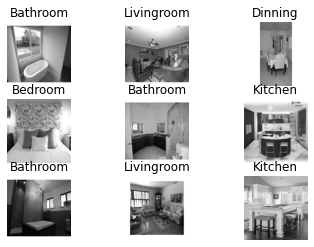

In [ ]:
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8').reshape(224,224), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')

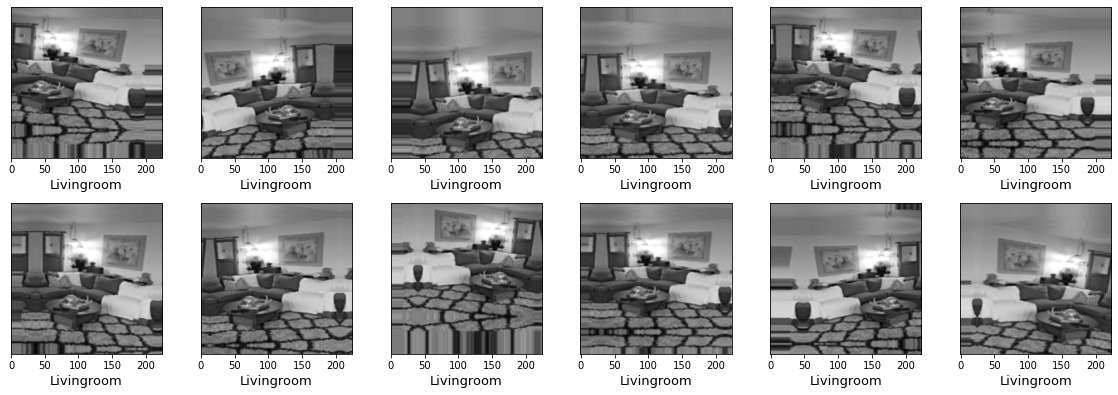

In [ ]:
data_augmentation_layer = Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    layers.experimental.preprocessing.RandomRotation((-0.02, 0.02), fill_mode='nearest'), 
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1, 0.3)),
    layers.experimental.preprocessing.RandomTranslation((-0.15, 0.15), (-0.15, 0.15), fill_mode='nearest', interpolation='bilinear',)
])
plt.figure(figsize=(16,16))
for image_iterator, labels_iterator in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(6, 6, i+1)
        plt.yticks([])
        aug_img = data_augmentation_layer(image_iterator)
        plt.imshow(aug_img[5].numpy().astype('uint8').reshape(224,224), cmap='gray')
        plt.xlabel(classes[labels_iterator[5]], fontsize=13)
    break
plt.tight_layout()    
plt.show()

In [ ]:
# Para optimizaciones

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# datagen = ImageDataGenerator(horizontal_flip=True)
# train_iterator = datagen.flow(train_ds)

In [ ]:
num_classes = len(class_names)

cnn = Sequential([
    # 90% training accuracy, 20% validation acc.
    data_augmentation_layer,
    layers.Conv2D(16, (15, 15), activation='relu', padding='same'),
    # layers.MaxPooling2D(),
    layers.Dropout(0.1), # TO AVOID OVERFITTING
    layers.Conv2D(32, (10, 10), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1), # TO AVOID OVERFITTING
    layers.Conv2D(32, (15, 15), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1), # TO AVOID OVERFITTING
    layers.Flatten(),
    layers.Dense(150, activation='relu'),
    layers.Dropout(0.1), # TO AVOID OVERFITTING
    layers.Dense(num_classes, activation='softmax')

    # layers.Conv2D(5, (10, 10), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    # data_augmentation_layer,
    # layers.Dropout(0.35), # TO AVOID OVERFITTING
    # layers.Conv2D(10, (10, 10), activation='relu', padding='same'),
    # layers.MaxPooling2D(),
    # layers.Conv2D(15, (10, 10), activation='relu', padding='same'),
    # # layers.Dropout(0.35), # TO AVOID OVERFITTING
    # # layers.Conv2D(5, (10, 10), activation='relu', padding='same'),
    # layers.MaxPooling2D(),
    # layers.Dropout(0.35), # TO AVOID OVERFITTING
    # # layers.Dropout(0.35), # TO AVOID OVERFITTING
    # layers.Flatten(),
    # layers.Dense(150, activation='relu'),
    # layers.Dropout(0.35), # TO AVOID OVERFITTING
    # # layers.Dropout(0.35), # TO AVOID OVERFITTING
    # layers.Dense(num_classes, activation='softmax')
])

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      3616      
                                                                 
 dropout (Dropout)           (None, 224, 224, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      51232     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 32)      0         
                                                      

In [ ]:
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 150

history = cnn.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/150
132/132 [==============================] - 5324s 40s/step - loss: 23.7403 - accuracy: 0.2279 - val_loss: 1.5880 - val_accuracy: 0.2429
Epoch 2/150
 75/132 [================>.............] - ETA: 36:29 - loss: 1.5838 - accuracy: 0.2383

In [ ]:
# cnn.save('/content/drive/MyDrive/Megaproyecto/saved_models')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_predicted = cnn.predict(val_ds)
y_predicted_label = [np.argmax(i) for i in y_predicted]

In [ ]:
values = val_ds.take(1)
plt.figure(figsize=(16,8))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().reshape((224,224)).astype('uint8'), cmap='gray')
        plt.title(f"{classes[np.argmax(y_predicted[i])]} - {classes[labels[i]]}")
        plt.axis('off')
# plt.imshow(val_ds.take(1))
# plt.xlabel(np.argmax(y_predicted[0]))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(val_ds.classes, y_predicted))


In [ ]:
y_predicted = cnn.predict(train_ds)
y_predicted_label = [np.argmax(i) for i in y_predicted]
plt.figure(figsize=(16,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().reshape((224,224)).astype('uint8'), cmap='gray')
        plt.title(f"{classes[y_predicted_label[i]]} - {classes[labels[i]]}")
        plt.axis('off')

In [ ]:
import cv2
test_real_kitch = '/content/drive/MyDrive/Megaproyecto/kitchen.png'
test_real_living = '/content/drive/MyDrive/Megaproyecto/living.png'
test_real_dining = '/content/drive/MyDrive/Megaproyecto/dining.png'

IMAGE_CHANNEL = 1 # or 3

def prepare(filepath):
    IMG_SIZE = 224
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

images_array= [prepare(img ) for img in [test_real_kitch, test_real_living, test_real_dining]]
plt.figure(figsize=(16,8))
for i in range(3):
  predicted = cnn.predict(images_array[i])
  ax = plt.subplot(2, 3, i+1)
  plt.imshow(images_array[i].reshape((224,224)).astype('uint8'), cmap='gray')
  plt.title(classes[np.argmax(predicted)])
  plt.axis('off')
  ax = plt.subplot(2,3, i+4)
  plt.bar(classes, predicted[0])

plt.show()